# Sales Orders Time Series Forecasting - ML Cohort WiD

_**Business Problem**: The demand planning team for a global food manufacturing company requires reliable forecasts for sales orders in order ensure order fulfillment and meet sales quotas. Reliable forecasts should support their goal in reducing over and under production. With over production comes a risk of food waste and with under production, food shortage. As a data scientist & consultant, you are provided with approximately 40 months (or 4 years) of data for 40 products that each need to be forecasted at monthly lags 1 and 2.​_

_**Data Source:** [Sell Out Sell In Forecasting Blog](https://towardsdatascience.com/sell-out-sell-in-forecasting-45637005d6ee)_, _[Github](https://github.com/BartoszSzablowski/Sell_Out_Sell_In_Forecasting)_

## Import Libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd
from math import sqrt

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# time
import datetime as dt
import time as time

# pipeline
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.ensemble import RandomForestRegressor

# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# model evaluation
from sklearn.metrics import mean_squared_error

## Data Access

In [2]:
# Read in data.
df = pd.read_csv('History_SellIn_SellOut.csv', sep=';')
df.head()

,PERIOD_TAG,product_group,customer_name,dispatches_SellIn,orders_SellIn,Sellout,numeric_distribution_selling_promotion,type_promo_1,type_promo_2
0,2016-08-07,Product_01,Customer_01,130,130,0.000000,0.0,0.0,0.0
1,2016-08-14,Product_01,Customer_01,4,5,102.274039,0.1,0.0,0.0
2,2016-08-21,Product_01,Customer_01,130,130,93.380644,0.0,0.0,0.0
3,2016-08-28,Product_01,Customer_01,61,61,101.162365,0.0,0.0,0.0
4,2016-09-04,Product_01,Customer_01,57,58,120.060829,0.1,0.0,0.0


In [3]:
# Data info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6804 entries, 0 to 6803
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   PERIOD_TAG                              6804 non-null   object 
 1   product_group                           6804 non-null   object 
 2   customer_name                           6804 non-null   object 
 3   dispatches_SellIn                       6804 non-null   int64  
 4   orders_SellIn                           6804 non-null   int64  
 5   Sellout                                 6804 non-null   float64
 6   numeric_distribution_selling_promotion  6804 non-null   float64
 7   type_promo_1                            6804 non-null   float64
 8   type_promo_2                            6804 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 478.5+ KB


In [4]:
# Keep copy of df for analysis later.
df_copy = df.copy()

In [5]:
# We are predicting orders, so, at the time of prediction, only orders will be available. Subset to necessary columns.
df = df[['PERIOD_TAG', 'product_group','orders_SellIn']]
# Rename columns for easier coding.
df.columns = ['period_start', 'sku', 'orders']
# Date col to datetype.
df['period_start'] = pd.to_datetime(df['period_start'])
# The problem defined by the business is to predict monthly sales orders, in this case find the month of each row.
df['month'] = df['period_start'].dt.to_period('M').dt.to_timestamp()
# Find year.
df['year'] = df['period_start'].astype(str).str[:4]
# Add month name column.
df['month_name'] = df['period_start'].dt.strftime("%B")

In [6]:
# Summary.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6804 entries, 0 to 6803
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   period_start  6804 non-null   datetime64[ns]
 1   sku           6804 non-null   object        
 2   orders        6804 non-null   int64         
 3   month         6804 non-null   datetime64[ns]
 4   year          6804 non-null   object        
 5   month_name    6804 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 319.1+ KB


In [7]:
# How many unique skus.
df.sku.nunique()

41

In [8]:
# How many month of data per sku.
print("Median no. months of data per sku : ", df.groupby('sku')['month'].nunique().median())
# How many years of data per sku.
print("Median no. years of data per sku : ", df.groupby('sku')['year'].nunique().median())

Median no. months of data per sku :  41.0
Median no. years of data per sku :  4.0


In [9]:
# Demand planners are most interested in the first two months or 6 weeks predictions. Option: TEST of model predicting weekly lag1-6 or monthly lag1-2 performs better.

# Groupby sku and week find the monthly sum of shipments and orders. Option: For use later.
df_week = df.groupby(['sku', 'period_start'])[['period_start', 'sku', 'orders']].agg({ 
    'orders':'sum'
}).reset_index()

# Groupby sku and period_start find the monthly sum of shipments and orders.
df = df.groupby(['sku', 'month', 'year', 'month_name'])[['month', 'year', 'month_name', 'sku', 'orders']].agg({ 
    'orders':'sum'
}).reset_index()

In [10]:
df_week.head()

,sku,period_start,orders
0,Product_01,2016-08-07,130
1,Product_01,2016-08-14,5
2,Product_01,2016-08-21,130
3,Product_01,2016-08-28,61
4,Product_01,2016-09-04,58


In [11]:
df.head()

,sku,month,year,month_name,orders
0,Product_01,2016-08-01,2016,August,326
1,Product_01,2016-09-01,2016,September,581
2,Product_01,2016-10-01,2016,October,559
3,Product_01,2016-11-01,2016,November,471
4,Product_01,2016-12-01,2016,December,634


## Cleaning

In [12]:
# check if any products with less than 3 years of data
less_than_3yr = []
for sku in df.sku.unique().tolist():
    data = df[df['sku']==sku]
    months = data.month.nunique()
    if months < 36:
        less_than_3yr.append(sku)
# keep record for later to observe if modelling is affected for skus with less than 2 or 3 years of data
less_than_3yr

['Product_03',
 'Product_09',
 'Product_13',
 'Product_23',
 'Product_28',
 'Product_29',
 'Product_30',
 'Product_40']

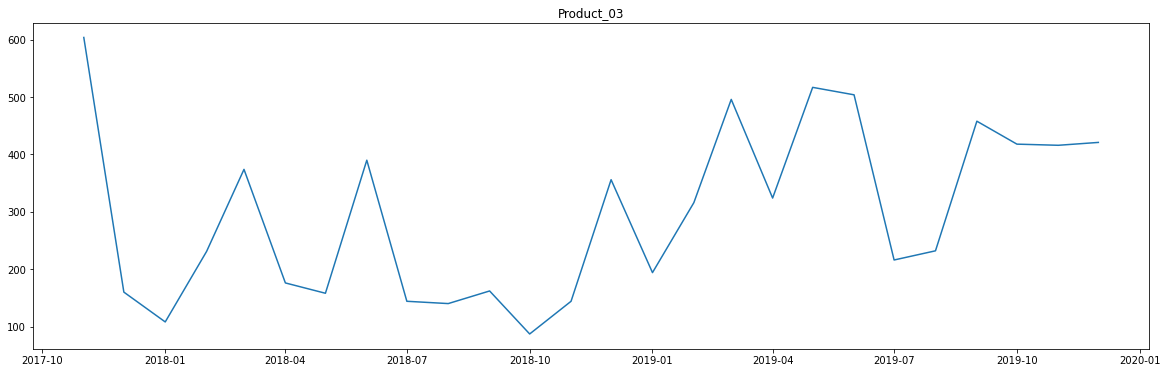

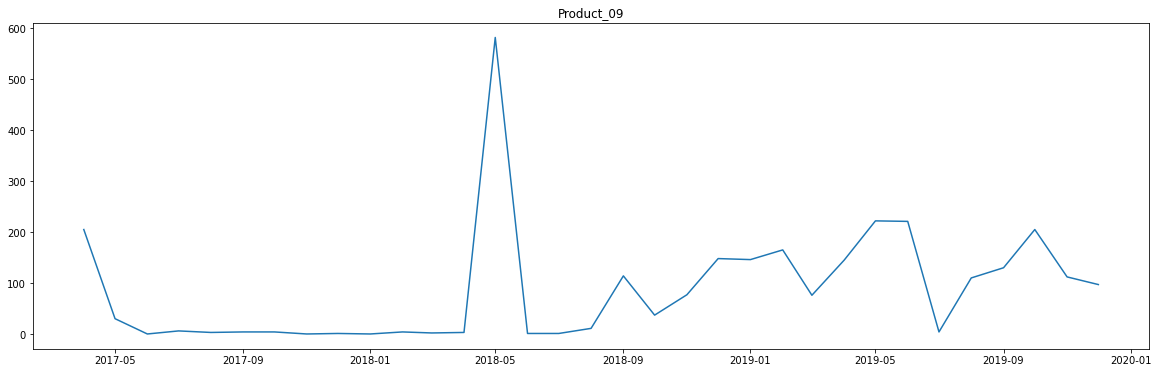

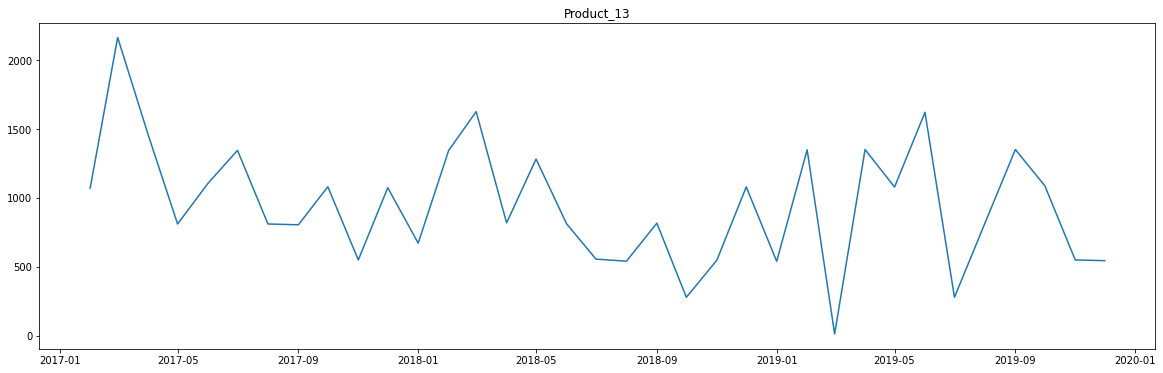

In [13]:
# Plot a sample of orders over time for products with less than 3 years data.
for sku in less_than_3yr[:3]:
    fig = plt.figure(facecolor = 'white', figsize = (20, 6))
    data = df[df['sku']==sku]
    dates = data.month.tolist()
    orders = data.orders.tolist()
    plt.plot(dates, orders)
    plt.title(sku)
    plt.show()

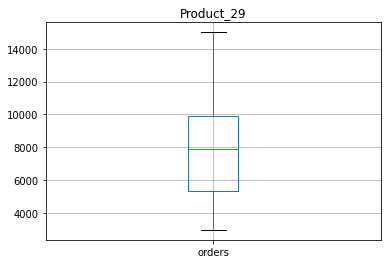

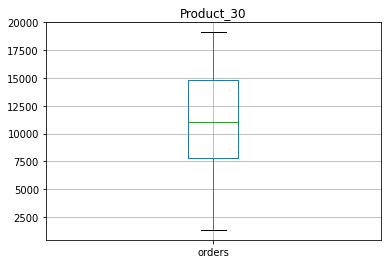

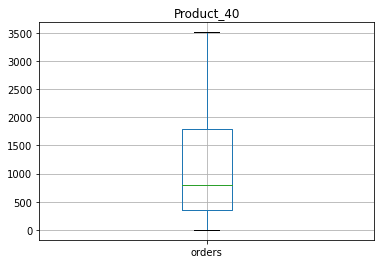

In [14]:
# Check for any outliers, for sample of products with less than 3 years data.
for sku in less_than_3yr[-3:]:
    boxplot = df[df['sku']==sku]
    boxplot.boxplot()
    plt.title(sku)
    plt.show()

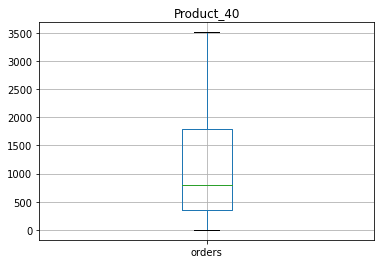

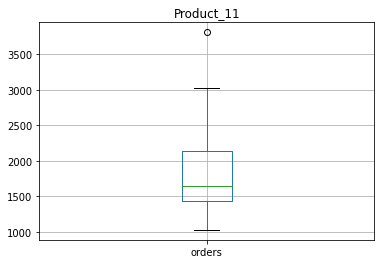

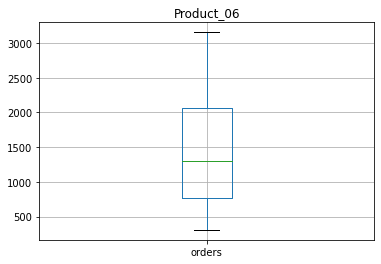

In [15]:
# Check for any outliers in all products, sample 3.
for sku in df.sample(n=3).sku.unique().tolist():
    boxplot = df[df['sku']==sku]
    boxplot.boxplot()
    plt.title(sku)
    plt.show()

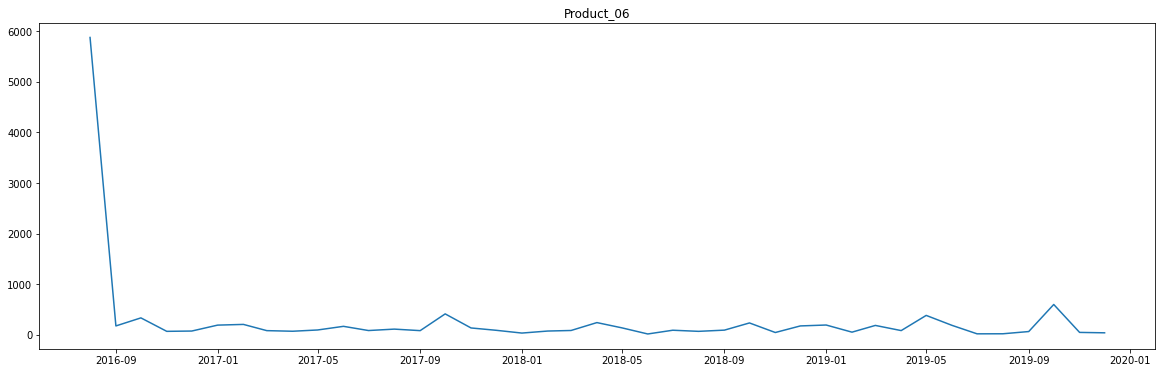

In [16]:
# Look more into product 38.
fig = plt.figure(facecolor = 'white', figsize = (20, 6))
data = df[df['sku']=='Product_38']
dates = data.month.tolist()
orders = data.orders.tolist()
plt.plot(dates, orders)
plt.title(sku)
plt.show()

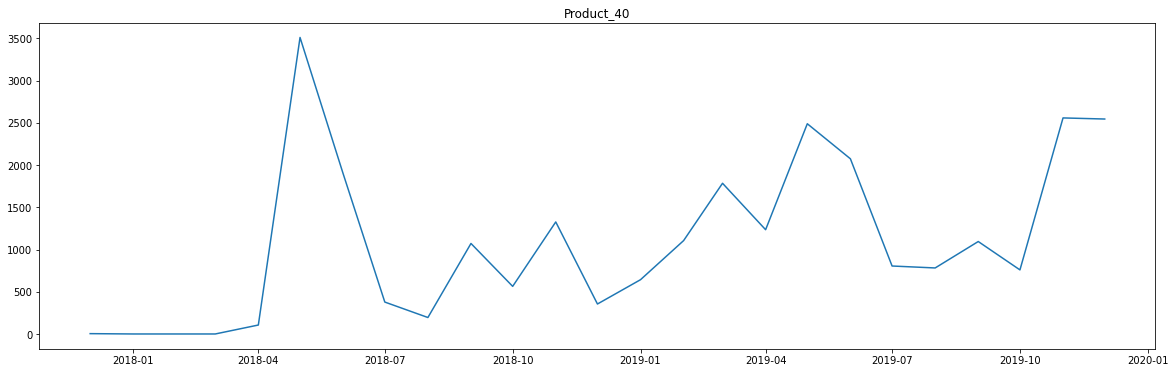

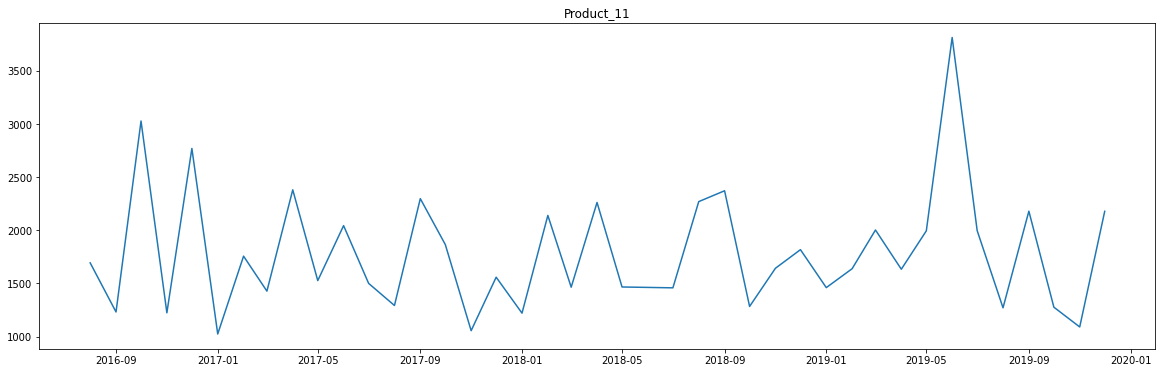

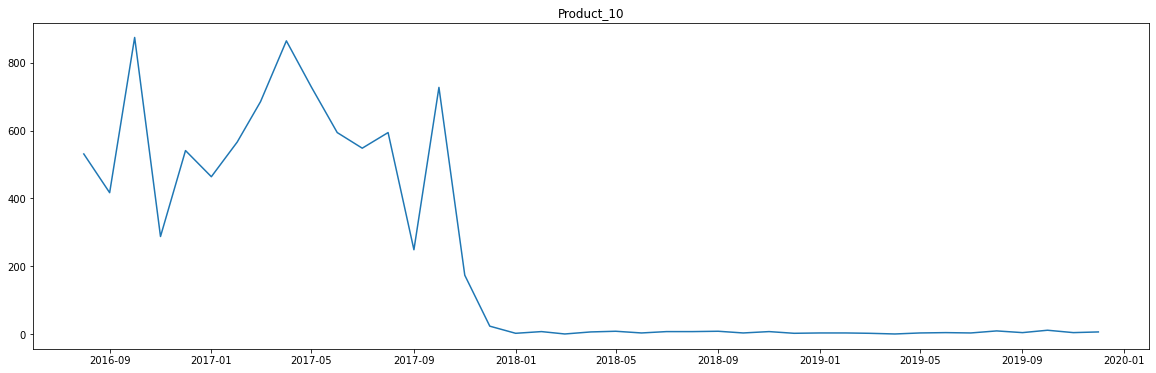

In [17]:
# Plot a sample of 3 product orders over time.
for sku in df.sample(n=3).sku.unique().tolist():
    fig = plt.figure(facecolor = 'white', figsize = (20, 6))
    data = df[df['sku']==sku]
    dates = data.month.tolist()
    orders = data.orders.tolist()
    plt.plot(dates, orders)
    plt.title(sku)
    plt.show()

In [18]:
# Any monthly orders of 0?
skus_monthly_order_zero = df[df['orders']==0].groupby('sku').month.count().index.unique().tolist()
# Observe any skus where monthly orders is 0.
for sku in skus_monthly_order_zero:
    data = df[df['sku']==sku].orders.tolist()
    print(sku, 'monthly orders : ', data)

Product_09 monthly orders :  [205, 30, 0, 6, 3, 4, 4, 0, 1, 0, 4, 2, 3, 582, 1, 1, 11, 114, 37, 77, 148, 146, 165, 76, 145, 222, 221, 4, 110, 130, 205, 112, 97]
Product_14 monthly orders :  [337, 443, 143, 9, 135, 102, 103, 86, 188, 44, 213, 77, 234, 413, 18, 95, 52, 42, 99, 93, 110, 111, 283, 388, 444, 67, 51, 85, 223, 43, 102, 318, 43, 276, 146, 8, 77, 19, 0, 0, 0]
Product_15 monthly orders :  [1915, 2669, 3540, 1935, 1906, 3392, 1874, 2049, 2595, 2540, 2339, 2984, 1798, 1517, 2924, 1579, 1129, 1044, 1385, 1364, 1738, 2012, 1601, 2079, 1278, 2042, 1693, 2535, 1517, 1344, 1658, 1381, 345, 519, 0, 0, 0, 0, 0, 0, 0]
Product_22 monthly orders :  [107, 431, 417, 86, 189, 448, 245, 177, 324, 64, 251, 87, 198, 260, 198, 45, 323, 129, 196, 239, 261, 280, 244, 368, 153, 217, 131, 436, 434, 140, 308, 458, 197, 501, 114, 325, 369, 2, 0, 0, 0]
Product_40 monthly orders :  [4, 0, 0, 0, 106, 3512, 1899, 378, 195, 1072, 564, 1327, 355, 643, 1106, 1785, 1235, 2490, 2075, 805, 782, 1095, 759, 2559, 2

-------
We see that some skus have an outlier at the beginning, some at the end, while other skus trends change over time. Some skus seem to have seasonality, while some do not. Action steps:
- It would be useful to use a robust ML model that can predict each sku orders given that there are different trends in each.
- Deal with outliers, such as the first data point for Product_38: options are, replace with median, drop observation, find seasonality and replace with appropriate value, use ML model that can detect outliers


-----------

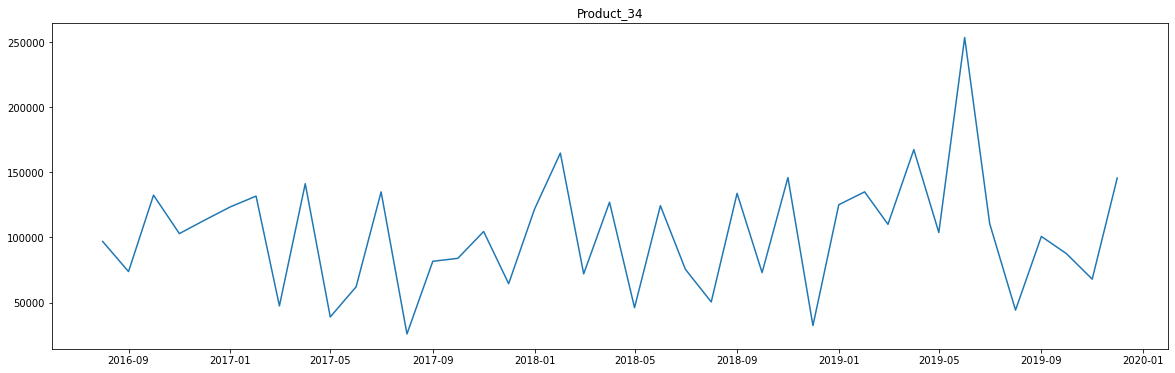

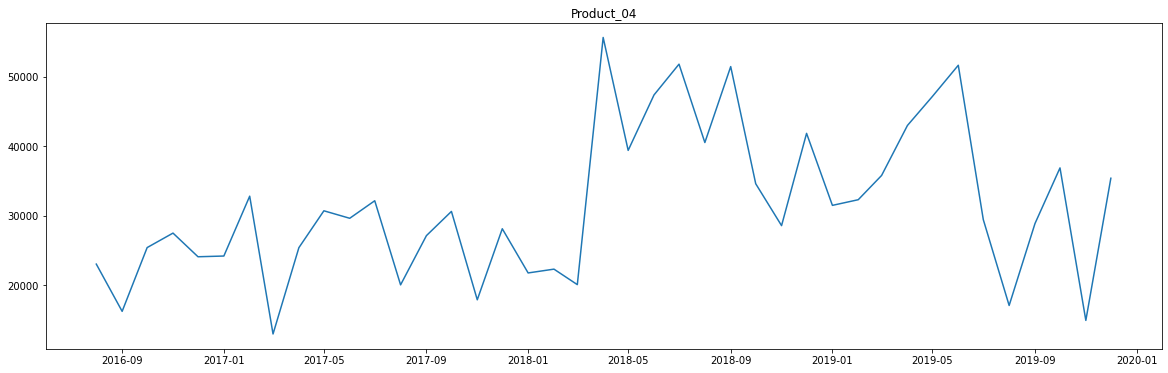

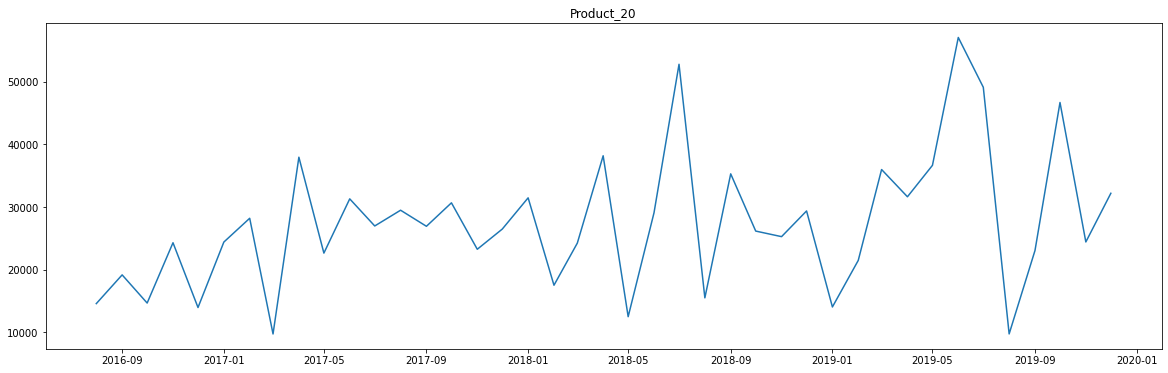

In [19]:
# Check which months are the busiest, select top 3.
busiest_months = df.groupby('sku')[['sku','orders']].agg({'orders':'sum'}).sort_values('orders', ascending=False)[:3].index.tolist()
# Plot a sample of 3 sku orders over time
for sku in busiest_months:
    fig = plt.figure(facecolor = 'white', figsize = (20, 6))
    data = df[df['sku']==sku]
    dates = data.month.tolist()
    orders = data.orders.tolist()
    plt.plot(dates, orders)
    plt.title(sku)
    plt.show()

In [20]:
# try the following models: seasonal naive, theta, mapa, and autots

## Modelling

In [21]:
data.head()

,sku,month,year,month_name,orders
749,Product_20,2016-08-01,2016,August,14578
750,Product_20,2016-09-01,2016,September,19168
751,Product_20,2016-10-01,2016,October,14667
752,Product_20,2016-11-01,2016,November,24304
753,Product_20,2016-12-01,2016,December,13953


In [22]:
# the code below is from https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/fbprophet/ensemble_forecast/uncertainty/simulation/2020/04/21/timeseries-part2.html#Importing-Data

In [26]:
#collapse-hide
#Author: Sandeep Pawar
#Version: 1.0
#Date Mar 27, 2020

import pandas as pd
import numpy as np
import itertools

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
plt.style.use('seaborn-white')
pd.plotting.register_matplotlib_converters()
%matplotlib inline

#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera as jb
from itertools import combinations

import fbprophet as Prophet


#library to use R in Python 
# import rpy2
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()
 


import warnings
warnings.filterwarnings("ignore")
np.random.seed(786)

In [29]:
# Make date col index.
data.set_index('month', inplace=True)
# Subset only necessary cols.
data = data[['orders']]
#Split into train and test
train = data.iloc[:-2]
test  = data.iloc[-2:]
#forecast horizon
h = 2
train_length = len(train)

print('train_length:',train_length, '\ntest_length:', len(test) )

#Creating BxCox transformed train & test to be used later
train_bcox, bcox_lam = boxcox(train["orders"])
print("BoxCox parameter to linearize the series:", bcox_lam.round(2))
test_bcox = boxcox(test["orders"], lmbda=bcox_lam)

train_log = np.log(train["orders"])

train_length: 39 
test_length: 2
BoxCox parameter to linearize the series: 0.33


In [36]:
#collapse-hide
#Create line chart for Training data. index is reset to use Date column
train_chart=alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='month', 
    y='orders', 
    tooltip=['month', 'orders'])

#Create Rolling mean. This centered rolling mean 
rolling_mean = alt.Chart(train.reset_index()).mark_trail(
    color='orange',
    size=1
).transform_window(
    rolling_mean='mean(orders)',
    frame=[-4,4]
).encode(
    x='month:T',
    y='rolling_mean:Q',
    size='orders'
)

#Add data labels
text = train_chart.mark_text(
    align='left',
    baseline='top',
    dx=5  # Moves text to right so it doesn't appear on top of the bar
).encode(
    text='orders:Q'
)

#Add zoom-in/out
scales = alt.selection_interval(bind='scales')

#Combine everything
(train_chart + rolling_mean +text).properties(
    width=600, 
    title="French Retail Orders & 4Q Rolling mean ( in '000)").add_selection(
    scales
)

alt.LayerChart(...)

In [37]:
# Applying seasonal naive model from blog:

def pysnaive(train_series,seasonal_periods,forecast_horizon):
    '''
    Python implementation of Seasonal Naive Forecast. 
    This should work similar to https://otexts.com/fpp2/simple-methods.html
    Returns two arrays
     > fitted: Values fitted to the training dataset
     > fcast: seasonal naive forecast
    
    Author: Sandeep Pawar
    
    Date: Apr 9, 2020
    
    Ver: 1.0
    
    train_series: Pandas Series
        Training Series to be used for forecasting. This should be a valid Pandas Series. 
        Length of the Training set should be greater than or equal to number of seasonal periods
        
    Seasonal_periods: int
        No of seasonal periods
        Yearly=1
        Quarterly=4
        Monthly=12
        Weekly=52
        

    Forecast_horizon: int
        Number of values to forecast into the future
    
    e.g. 
    fitted_values = pysnaive(train,12,12)[0]
    fcast_values = pysnaive(train,12,12)[1]
    '''
    
    if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
        last_season=train_series.iloc[-seasonal_periods:]
        
        reps=np.int(np.ceil(forecast_horizon/seasonal_periods))
        
        fcarray=np.tile(last_season,reps)
        
        fcast=pd.Series(fcarray[:forecast_horizon])
        
        fitted = train_series.shift(seasonal_periods)
        
    else:
        fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
    return fitted, fcast

In [38]:
# Before I create the model, I am going to create a dataframe to store all out-of=sample forecasts and the test set
predictions = test.copy()

In [54]:
# Determine how many seasonal periods
seasonal_periods = int((len(data))/12)

#Fitted values
py_snaive_fit = pysnaive(train["orders"], 
                     seasonal_periods=seasonal_periods,
                     forecast_horizon=2)[0]

#forecast
py_snaive = pysnaive(train["orders"], 
                     seasonal_periods=seasonal_periods,
                     forecast_horizon=2)[1]

#Residuals
py_snaive_resid = (train["orders"] - py_snaive_fit).dropna()




predictions["py_snaive"] = py_snaive.values 


predictions

,orders,py_snaive
month,,
2019-11-01,24428,9734
2019-12-01,32206,23058


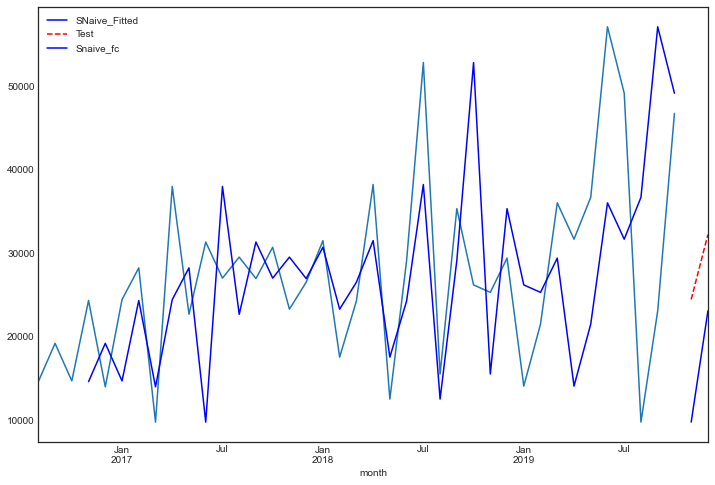

In [56]:
pd.plotting.register_matplotlib_converters()
train["orders"].plot(figsize=(12,8))#, style="--", color="gray", legend=True, label="Train")
py_snaive_fit.plot(color="b", legend=True, label="SNaive_Fitted")
predictions["orders"].plot(style="--",color="r", legend=True, label="Test")
predictions["py_snaive"].plot(color="b", legend=True, label="Snaive_fc");

In [58]:
def accuracy(y1,y2):
    
    accuracy_df=pd.DataFrame()
    
    rms_error = np.round(rmse(y1, y2),1)
    
    map_error = np.round(np.mean(np.abs((np.array(y1) - np.array(y2)) / np.array(y1))) * 100,1)
           
    accuracy_df=accuracy_df.append({"RMSE":rms_error, "%MAPE": map_error}, ignore_index=True)
    
    return accuracy_df

In [61]:
#Training score
accuracy(train["orders"].iloc[-len(py_snaive_fit.dropna()):], py_snaive_fit.dropna())

,RMSE,%MAPE
0,12685.5,41.4


In [62]:
#Test score
accuracy(predictions["orders"], predictions["py_snaive"])

,RMSE,%MAPE
0,12239.3,44.3
